## Download and unpack Math Culture's Custom Handwritten Character Image Dataset

In [1]:
!rm -r /content/dataset
!tar -xvf /content/dataset.tar.gz

rm: cannot remove '/content/dataset': No such file or directory
./._dataset
./dataset/
./dataset/._.DS_Store
./dataset/.DS_Store
./dataset/._train.txt
./dataset/train.txt
./dataset/._Annotations
./dataset/Annotations/
./dataset/._JPEGImages
./dataset/JPEGImages/
./dataset/._jpegToJpg.sh
./dataset/jpegToJpg.sh
./dataset/._val.txt
./dataset/val.txt
./dataset/JPEGImages/._four-11.jpg
./dataset/JPEGImages/four-11.jpg
./dataset/JPEGImages/._zeros-7.jpg
./dataset/JPEGImages/zeros-7.jpg
./dataset/JPEGImages/._sevens-4.jpg
./dataset/JPEGImages/sevens-4.jpg
./dataset/JPEGImages/._zeros-14.jpg
./dataset/JPEGImages/zeros-14.jpg
./dataset/JPEGImages/._y-5.jpg
./dataset/JPEGImages/y-5.jpg
./dataset/JPEGImages/._y-4.jpg
./dataset/JPEGImages/y-4.jpg
./dataset/JPEGImages/._eight-c1.jpg
./dataset/JPEGImages/eight-c1.jpg
./dataset/JPEGImages/._zeros-15.jpg
./dataset/JPEGImages/zeros-15.jpg
./dataset/JPEGImages/._sevens-5.jpg
./dataset/JPEGImages/sevens-5.jpg
./dataset/JPEGImages/._zeros-6.jpg
./dataset/

## Define custom Dataset class for MathCulture Handwritten Character Image Dataset (MCImageDataset)

In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import linecache
import xml.etree.ElementTree as ET

# Define the class PyTorch Custom Dataset class for Math Culture's dataset of handwritten characters
# /content/dataset/JPEGImages/  -> the .jpg image set (training+validation)
# /content/dataset/Annotations/ -> set of .xmls that correspond to each image name (i.e. 000564.jpg has an annotation .xml titled 000564.xml) 
# an annotation includes: class label and ground-truth bounding box
class MCImageDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["background","zero","one","two","three","four","five","six","seven","eight","nine","plus","minus","mult","division","lpar","rpar","equal","x","y","z"]
        self.num_classes = len(self.classes)
        
    def __len__(self):
        # Length of the dataset is the number of lines in the train.txt file
        return sum(1 for line in open(self.txt_file))

    def __getitem__(self,index):
        # linecache.getline() index starts at 1
        # image file path for current index
        image_path = os.path.join(self.root_dir,"JPEGImages/",linecache.getline(self.txt_file,index+1).strip()[:-4] + ".jpg")
        # annotation file path for current index 
        annotation_path = os.path.join(self.root_dir,"Annotations/",linecache.getline(self.txt_file,index+1).strip()[:-4] + ".xml")
        # read the image as a PIL image
        image = read_image(image_path)
        # normalize the image
        image = image.float() / 255

        # begin xml parsing
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        # a test image may contain multiple objects, and therefore multiple class labels/bounding boxes per image
        labels = []
        boxes = []
        # for each object in the current annotation file
        for obj in root.findall("object"):
            # add the label to the labels list
            name = obj.find('name').text
            # encode the label as by its index in the Dataset's classes list
            encoded_label = self.classes.index(name)
            labels.append(encoded_label)

            # add the bounding box to the bounding box list
            bbox = obj.find('bndbox')
            x1,y1,x2,y2 = int(bbox.find('xmin').text), int(bbox.find('ymin').text), int(bbox.find('xmax').text),int(bbox.find('ymax').text)
            boxes.append([x1,y1,x2,y2])

        if self.transform:
            image = self.transform(image)

        # convert boxes and labels to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # area and iscrowd satisfies COCO's eval tool, although they are not used for this project
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        num_objs = len(root.findall("object"))
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # create a dictionary (target) that includes all of the objects labels and bboxes
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = iscrowd

        # return the image and its annotation
        return image,target

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Custom collate function to modify how the PyTorch Dataloader handles our data
def collate_fn(batch):
    base_image_list, target_list = [],[]
    for _base_image, _target in batch:
        base_image_list.append(_base_image)
        target_list.append(_target)
    return base_image_list,target_list

# Given an image, a list of bounding boxes, and a list of labels
# Draw bounding boxes and each label around each object
def draw_boxes_on_image(image,boxes,labels):
    fig, ax = plt.subplots(figsize=(6,6)) # set figure size to 6x6inches
    ax.imshow(image.permute(1, 2, 0).cpu())
    classes = ["background","zero","one","two","three","four","five","six","seven","eight","nine","plus","minus","mult","division","lpar","rpar","equal","x","y","z"]


    # x1, y1 is the upper-left corner point, x2, y2 is the bottom-left corner point
    for i,box in enumerate(boxes):
        x1, y1, x2, y2 = box 
        w, h = (x2-x1), (y2-y1)
        bounding_box = mpatches.Rectangle((x1,y1), w, h, fill=False, edgecolor='green', linewidth=1)
        ax.add_patch(bounding_box)
        ax.text(x1,(y1-5),classes[labels[i].item()],verticalalignment='top', color='white',fontsize=10,weight='bold')

    plt.axis('off')
    plt.show()

In [8]:
# Import COCO evaluation tools
# Clone PyTorch vision library to use some helper functions for object detector training 
!pip install pycocotools --quiet

!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.


## train_one_epoch() and evaluate() from https://github.com/pytorch/vision/blob/main/references/detection/engine.py

In [9]:
import math
import sys
import time
import torch
import torchvision.models.detection.mask_rcnn
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

# A function that trains the model for one epoch
def train_one_epoch(model, optimizer,data_loader, device, epoch, print_freq):
    # set the model to training mode
    model.train()
    header = f"Epoch: [{epoch}]"

    # for each batch of image in the dataloader
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        # backpropagate the updated weights
        losses.backward()
        optimizer.step()

# A function that evaluates the model using COCO Dataset API
# mAP (mean average precision) for different IoU thresholds
def evaluate(model, data_loader, device):
    cpu_device = torch.device("cpu")
    model.eval()
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    coco_evaluator = CocoEvaluator(coco, ["bbox"])

    with torch.no_grad():
      for images, targets in data_loader:
          images = list(img.to(device) for img in images)

          if torch.cuda.is_available():
            torch.cuda.synchronize()
          model_time = time.time()
          outputs = model(images)

          outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
          model_time = time.time() - model_time

          res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
          coco_evaluator.update(res)

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

In [10]:
# A helper function that counts how many bounding boxes for each class are in a dataloader
def bboxes_per_class(dataloader):

  classes = dataloader.dataset.classes
  d = {}
  for i, data in enumerate(dataloader, 0):
    image, targets = data
    labels = targets[0]["labels"]
    for label in labels:
      class_name = classes[label.item()]
      d[class_name] = d.get(class_name, 0) + 1
  print("bboxes per class:")
  print(d)

In [11]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Determine what device the host is using (CPU or GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create the training set and testing set using train.txt and val.txt respectively
trainset = MCImageDataset("/content/dataset/train.txt","/content/dataset/")
valset = MCImageDataset("/content/dataset/val.txt","/content/dataset/")

num_classes = trainset.num_classes

# Create a dataloader for the training set and testing set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=4,collate_fn=collate_fn)
testloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=4,collate_fn=collate_fn)

# this only works correctly if the dataloader's batch_size=1
# get the bboxes_per_class for analytics
bboxes_per_class(trainloader)

# load a Faster R-CNN model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9,weight_decay=0.0005)

# Define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

# Train for 10 epochs
num_epochs = 10 

for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer,trainloader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, testloader, device=device)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


bboxes per class:
{'x': 362, 'six': 442, 'y': 464, 'three': 764, 'mult': 316, 'five': 591, 'nine': 908, 'eight': 372, 'two': 521, 'seven': 598, 'division': 303, 'lpar': 438, 'plus': 498, 'rpar': 499, 'one': 451, 'zero': 543, 'four': 340, 'equal': 293, 'z': 342, 'minus': 54}


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


creating index...
index created!
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.280
 Average Recall 

1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


real #boxes:  55
predicted #boxes:  56
nms predicted #boxes:  56


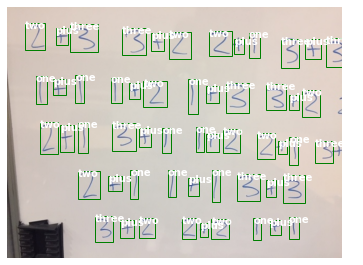

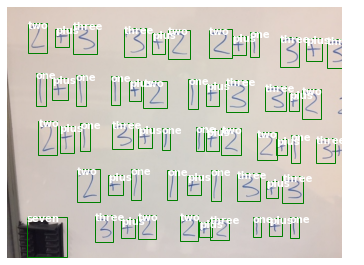

[11, 11, 11, 4, 11, 11, 11, 11, 2, 2, 11, 4, 4, 11, 4, 4, 11, 11, 4, 11, 2, 3, 4, 11, 11, 2, 4, 4, 2, 3, 11, 3, 11, 11, 2, 3, 2, 2, 2, 3, 2, 2, 3, 11, 4, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 8]
real #boxes:  55
predicted #boxes:  56
nms predicted #boxes:  56


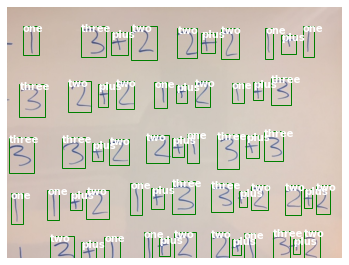

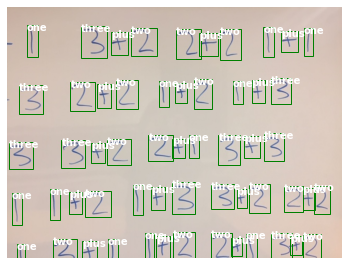

[11, 4, 3, 11, 3, 4, 4, 3, 2, 11, 4, 11, 11, 4, 3, 3, 2, 11, 3, 2, 4, 11, 2, 3, 2, 4, 2, 2, 2, 11, 2, 2, 11, 11, 11, 4, 11, 3, 3, 2, 11, 11, 3, 4, 11, 2, 11, 3, 3, 3, 11, 4, 3, 2, 3, 3]
real #boxes:  50
predicted #boxes:  55
nms predicted #boxes:  55


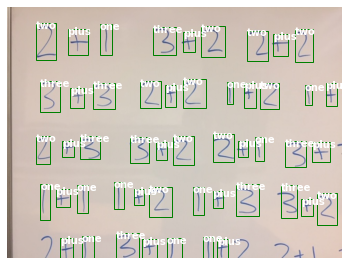

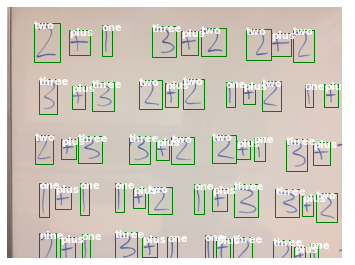

[11, 11, 11, 4, 11, 3, 11, 11, 4, 4, 4, 11, 11, 11, 3, 2, 11, 4, 3, 11, 3, 11, 2, 4, 2, 2, 4, 11, 11, 2, 3, 3, 2, 11, 11, 2, 2, 4, 11, 2, 3, 11, 3, 3, 3, 2, 3, 2, 4, 2, 3, 10, 4, 4, 11]
real #boxes:  65
predicted #boxes:  64
nms predicted #boxes:  64


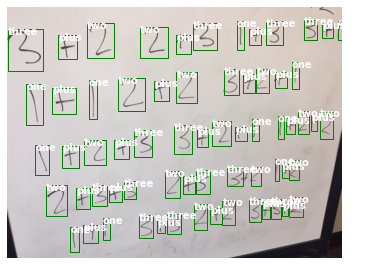

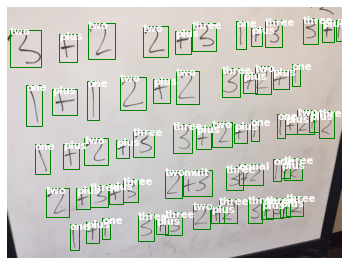

[4, 11, 3, 11, 3, 11, 11, 4, 11, 4, 11, 11, 3, 2, 4, 2, 2, 4, 11, 11, 11, 11, 4, 2, 11, 3, 11, 4, 11, 3, 4, 4, 4, 11, 2, 2, 11, 3, 4, 11, 11, 3, 2, 11, 11, 4, 2, 2, 3, 3, 2, 2, 3, 3, 13, 4, 4, 4, 4, 3, 11, 11, 17, 4]
real #boxes:  72
predicted #boxes:  65
nms predicted #boxes:  65


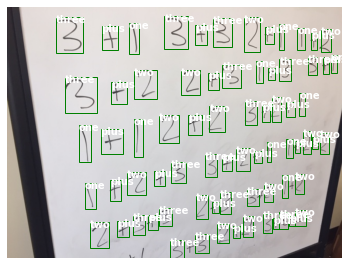

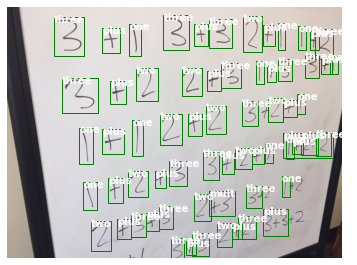

[4, 4, 11, 11, 4, 11, 11, 11, 11, 4, 2, 3, 4, 2, 2, 11, 2, 11, 11, 11, 3, 2, 11, 11, 2, 4, 11, 4, 11, 4, 11, 3, 2, 3, 2, 4, 3, 2, 4, 11, 11, 4, 3, 4, 11, 3, 3, 11, 11, 2, 4, 3, 2, 2, 4, 13, 11, 3, 4, 11, 3, 4, 4, 11, 4]
real #boxes:  63
predicted #boxes:  62
nms predicted #boxes:  62


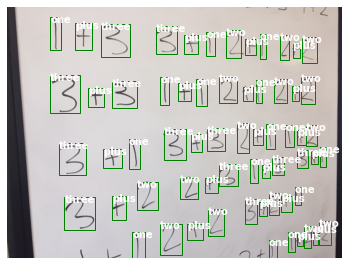

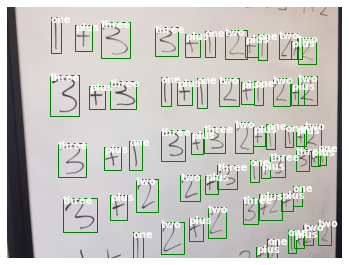

[4, 11, 3, 4, 4, 11, 2, 3, 11, 11, 11, 4, 4, 11, 4, 4, 2, 4, 2, 3, 2, 11, 2, 2, 11, 3, 2, 2, 11, 11, 2, 3, 11, 2, 4, 2, 3, 11, 11, 2, 11, 4, 11, 3, 3, 2, 11, 3, 11, 4, 3, 2, 3, 2, 4, 3, 11, 11, 3, 11, 11, 3]
real #boxes:  57
predicted #boxes:  60
nms predicted #boxes:  60


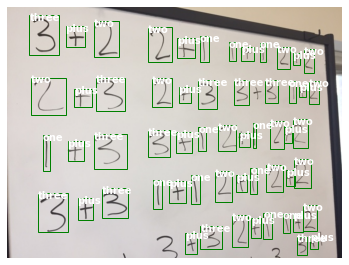

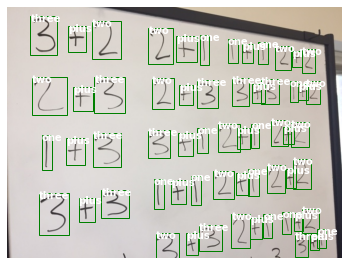

[11, 4, 11, 11, 4, 3, 3, 11, 3, 11, 11, 4, 11, 11, 11, 4, 4, 2, 3, 2, 3, 2, 2, 2, 4, 4, 3, 2, 11, 4, 3, 4, 2, 11, 2, 2, 11, 2, 2, 3, 2, 3, 11, 3, 3, 11, 11, 2, 11, 11, 4, 11, 3, 3, 11, 3, 4, 3, 3, 11]
real #boxes:  49
predicted #boxes:  50
nms predicted #boxes:  50


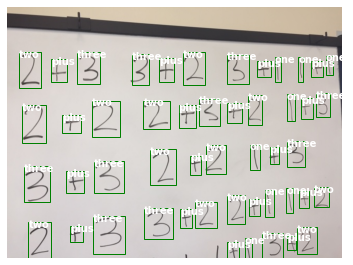

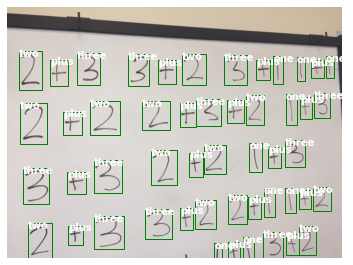

[11, 11, 11, 3, 4, 11, 11, 3, 4, 11, 11, 11, 11, 4, 4, 11, 3, 11, 4, 4, 4, 4, 11, 4, 2, 11, 3, 2, 3, 2, 4, 11, 2, 2, 3, 3, 11, 2, 2, 2, 3, 4, 3, 11, 11, 3, 3, 3, 3, 2]
real #boxes:  57
predicted #boxes:  57
nms predicted #boxes:  57


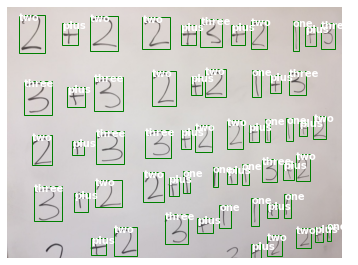

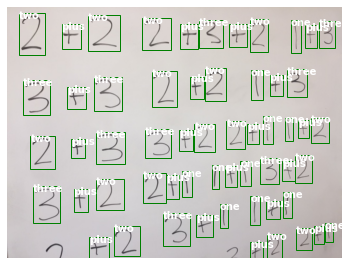

[3, 4, 4, 11, 3, 11, 4, 4, 11, 4, 11, 3, 4, 3, 11, 11, 11, 11, 11, 4, 3, 2, 2, 4, 3, 11, 2, 11, 11, 2, 2, 2, 11, 2, 3, 11, 4, 11, 2, 2, 11, 11, 2, 3, 3, 11, 3, 4, 3, 11, 11, 2, 3, 3, 3, 3, 3]
real #boxes:  59
predicted #boxes:  58
nms predicted #boxes:  58


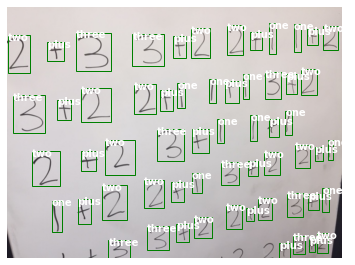

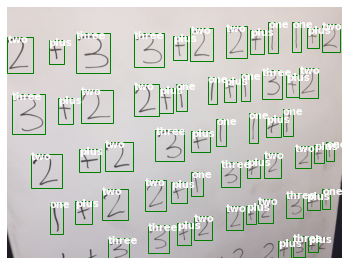

[3, 3, 11, 3, 3, 11, 4, 4, 4, 11, 11, 11, 2, 2, 2, 3, 11, 4, 2, 11, 4, 4, 4, 4, 2, 11, 11, 11, 11, 2, 11, 2, 3, 2, 11, 11, 2, 11, 3, 11, 11, 3, 2, 3, 11, 2, 3, 11, 3, 2, 3, 4, 3, 3, 3, 3, 11, 4]
real #boxes:  58
predicted #boxes:  58
nms predicted #boxes:  58


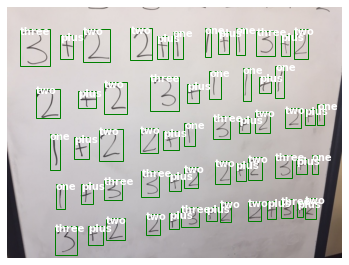

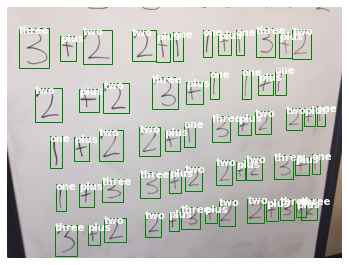

[3, 11, 4, 3, 3, 11, 3, 4, 2, 4, 4, 11, 4, 11, 3, 11, 4, 4, 4, 2, 11, 11, 11, 11, 11, 2, 2, 11, 3, 2, 2, 11, 11, 11, 11, 2, 11, 2, 11, 11, 11, 4, 11, 3, 3, 2, 4, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 4]
real #boxes:  17
predicted #boxes:  17
nms predicted #boxes:  17


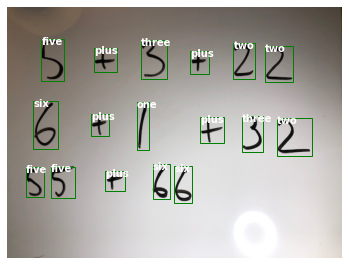

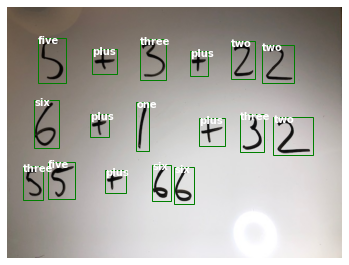

[7, 3, 7, 11, 11, 11, 11, 4, 3, 7, 2, 6, 4, 6, 11, 3, 4]
real #boxes:  27
predicted #boxes:  28
nms predicted #boxes:  28


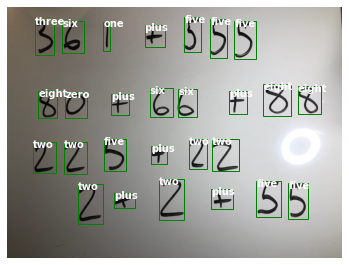

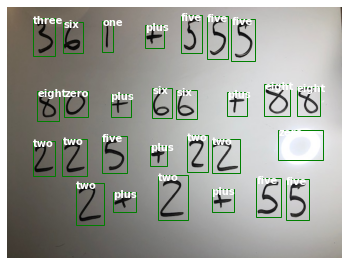

[1, 11, 9, 7, 11, 7, 9, 6, 11, 7, 4, 11, 3, 6, 11, 3, 2, 9, 6, 3, 6, 6, 3, 6, 11, 3, 3, 1]
real #boxes:  27
predicted #boxes:  27
nms predicted #boxes:  27


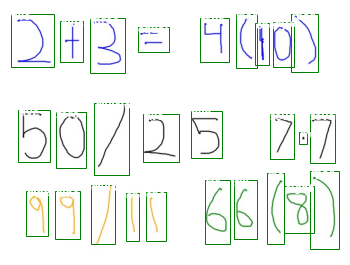

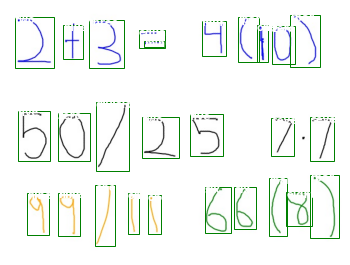

[5, 1, 10, 10, 8, 15, 7, 1, 2, 2, 7, 3, 4, 3, 2, 15, 6, 9, 6, 8, 11, 14, 16, 16, 17, 2, 12]
real #boxes:  31
predicted #boxes:  33
nms predicted #boxes:  33


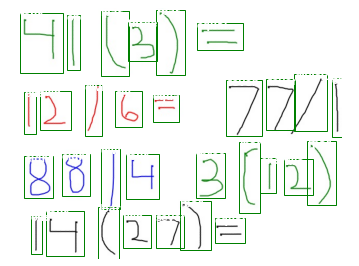

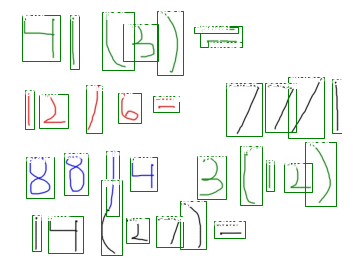

[5, 3, 5, 5, 8, 3, 2, 2, 8, 2, 8, 15, 7, 2, 3, 4, 2, 17, 16, 9, 16, 17, 17, 14, 16, 4, 15, 2, 9, 2, 15, 12, 12]
real #boxes:  20
predicted #boxes:  20
nms predicted #boxes:  20


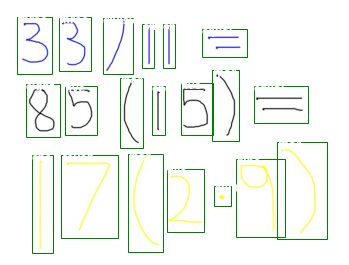

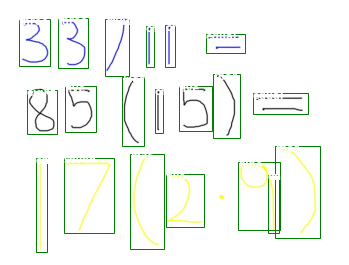

[8, 2, 2, 9, 2, 3, 2, 15, 10, 4, 4, 17, 15, 6, 16, 6, 16, 17, 14, 2]
real #boxes:  38
predicted #boxes:  37
nms predicted #boxes:  37


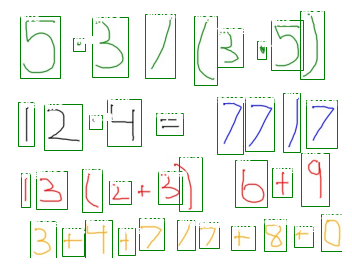

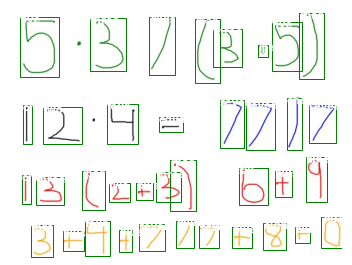

[5, 3, 5, 10, 11, 2, 11, 8, 3, 11, 4, 8, 2, 6, 8, 8, 16, 4, 11, 4, 11, 15, 14, 15, 1, 4, 9, 2, 4, 8, 7, 17, 14, 6, 16, 11, 15]
real #boxes:  34
predicted #boxes:  34
nms predicted #boxes:  34


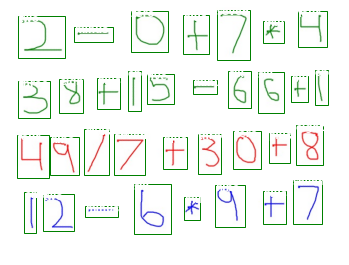

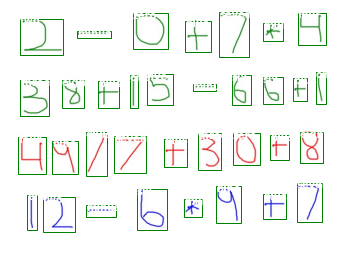

[8, 1, 5, 5, 1, 11, 2, 3, 11, 11, 11, 11, 8, 3, 11, 4, 4, 10, 8, 2, 6, 9, 2, 7, 14, 9, 7, 13, 13, 12, 12, 12, 10, 7]
real #boxes:  31
predicted #boxes:  32
nms predicted #boxes:  32


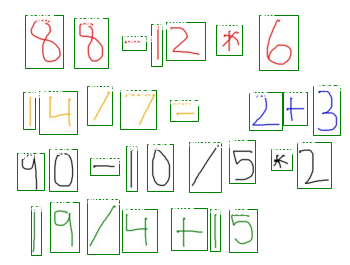

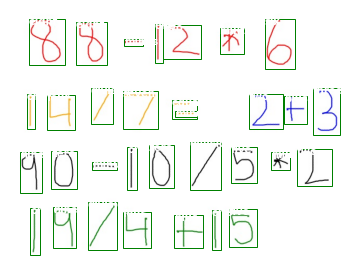

[5, 10, 1, 8, 7, 11, 11, 2, 5, 6, 2, 3, 2, 1, 2, 4, 2, 9, 6, 13, 14, 3, 3, 13, 14, 14, 10, 17, 12, 9, 12, 12]
real #boxes:  33
predicted #boxes:  33
nms predicted #boxes:  33


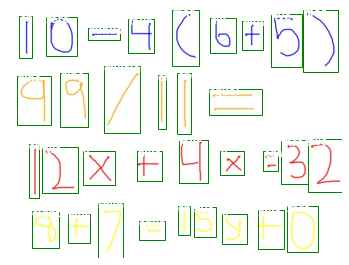

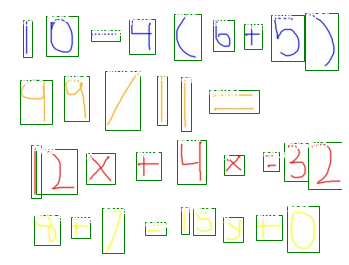

[5, 5, 1, 1, 11, 18, 2, 11, 2, 2, 3, 2, 15, 4, 11, 17, 3, 11, 10, 10, 14, 16, 7, 2, 6, 18, 8, 12, 6, 17, 17, 4, 18]
real #boxes:  34
predicted #boxes:  35
nms predicted #boxes:  35


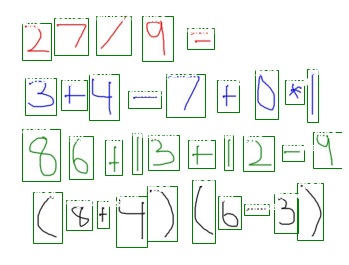

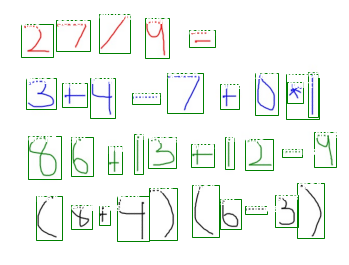

[5, 5, 8, 11, 11, 2, 2, 3, 8, 14, 3, 15, 11, 11, 2, 4, 7, 16, 16, 4, 4, 15, 10, 17, 7, 11, 10, 5, 13, 9, 12, 9, 12, 12, 1]


In [12]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

print(torch.cuda.device_count())

for i, data in enumerate(testloader, 0):
    images, targets = data
    model.eval()
    with torch.no_grad():
        prediction = model([images[0].to(device)])[0]
        nms_prediction = apply_nms(prediction, iou_thresh=0.3)

    print('real #boxes: ', len(targets[0]['labels']))
    print('predicted #boxes: ', len(prediction['labels']))
    print('nms predicted #boxes: ', len(nms_prediction['labels']))

    draw_boxes_on_image(images[0],targets[0]['boxes'],targets[0]['labels'])
    #draw_boxes_on_image(image,prediction['boxes'],prediction['labels'])

    draw_boxes_on_image(images[0],nms_prediction['boxes'],nms_prediction['labels'])
    print(nms_prediction['labels'].tolist())
    